Epoch 1/5
12/12 [==============================] - 54s 5s/step - loss: 0.1568 - val_loss: 0.0788
Epoch 2/5
12/12 [==============================] - 52s 4s/step - loss: 0.0910 - val_loss: 0.0620
Epoch 3/5
12/12 [==============================] - 52s 4s/step - loss: 0.0780 - val_loss: 0.0533
Epoch 4/5
12/12 [==============================] - 52s 4s/step - loss: 0.0661 - val_loss: 0.0439
Epoch 5/5
12/12 [==============================] - 52s 4s/step - loss: 0.0564 - val_loss: 0.0358


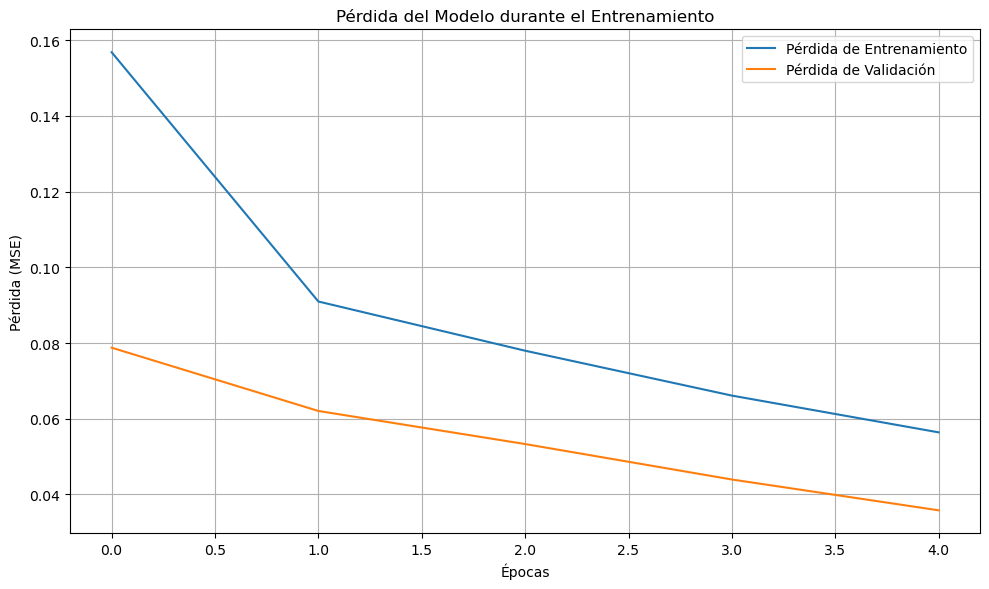

2/2 [==============================] - 5s 1s/step


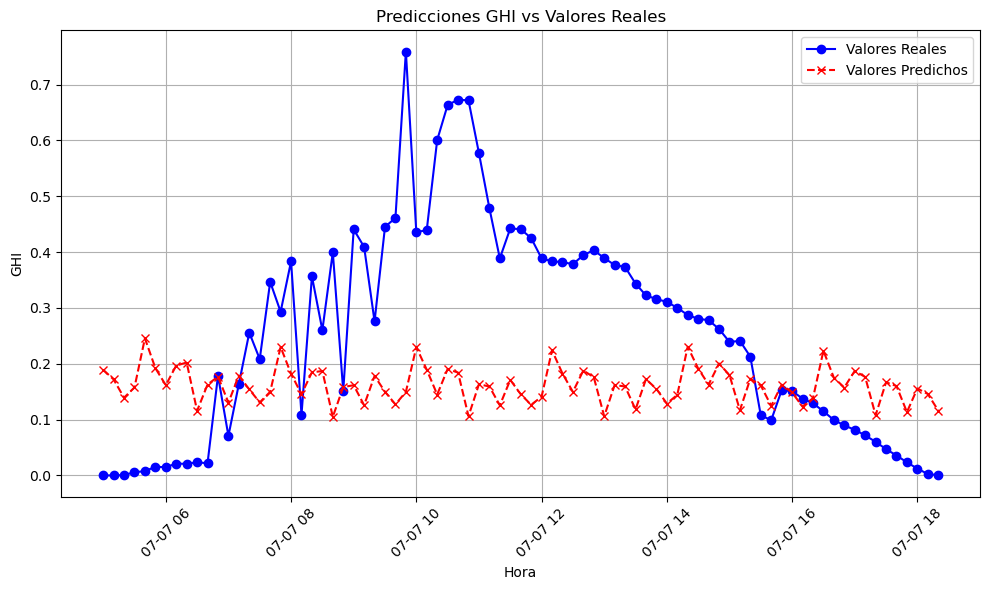

In [3]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    # Crear un patrón de nombre para la imagen con año, mes, día, hora y minuto
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    
    # Buscar archivos en la carpeta que coincidan con el patrón de nombre base
    for second in range(60):  # Revisar segundos de 00 a 59
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    
    # Retornar None si no se encontró una imagen correspondiente
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    valid_timestamps = []  # Lista para almacenar los timestamps que tienen tanto imagen como GHI

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            valid_timestamps.append(timestamp)  # Añadir el timestamp válido
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps
    

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    # Asegurar que las longitudes coinciden entre timestamps y valores de GHI
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))

    # Recortar a la longitud mínima para evitar errores de dimensionamiento
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(64, return_sequences=False)(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred)(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer='adam', loss='mse')

    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=5, batch_size=32)

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train, valid_timestamps_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, scaler_test, valid_timestamps_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    # Entrenar el modelo con los datos de entrenamiento
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    # Función para graficar el desempeño del modelo
    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Graficar el desempeño del modelo
    plot_training_history(history)

    # Verificar si hay suficientes datos para crear secuencias de predicción
    if len(X_images_test) > seq_len:
        # Crear secuencias de entrada y salida con las nuevas imágenes y valores GHI
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            # Hacer predicciones con el modelo en las nuevas secuencias
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            # Invertir la normalización de los valores predichos y reales
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            # Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')

            # Graficar los resultados predichos y reales para las nuevas fechas
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")

Epoch 1/30
23/23 [==============================] - 54s 2s/step - loss: 7.8566 - val_loss: 7.1580
Epoch 2/30
23/23 [==============================] - 52s 2s/step - loss: 6.7549 - val_loss: 6.2358
Epoch 3/30
23/23 [==============================] - 52s 2s/step - loss: 5.8708 - val_loss: 5.4064
Epoch 4/30
23/23 [==============================] - 52s 2s/step - loss: 5.0781 - val_loss: 4.6594
Epoch 5/30
23/23 [==============================] - 52s 2s/step - loss: 4.3589 - val_loss: 3.9912
Epoch 6/30
23/23 [==============================] - 52s 2s/step - loss: 3.7225 - val_loss: 3.3958
Epoch 7/30
23/23 [==============================] - 52s 2s/step - loss: 3.1593 - val_loss: 2.8634
Epoch 8/30
23/23 [==============================] - 52s 2s/step - loss: 2.6619 - val_loss: 2.4016
Epoch 9/30
23/23 [==============================] - 58s 3s/step - loss: 2.2298 - val_loss: 2.0072
Epoch 10/30
23/23 [==============================] - 54s 2s/step - loss: 1.8587 - val_loss: 1.6634
Epoch 11/30
23/23 [

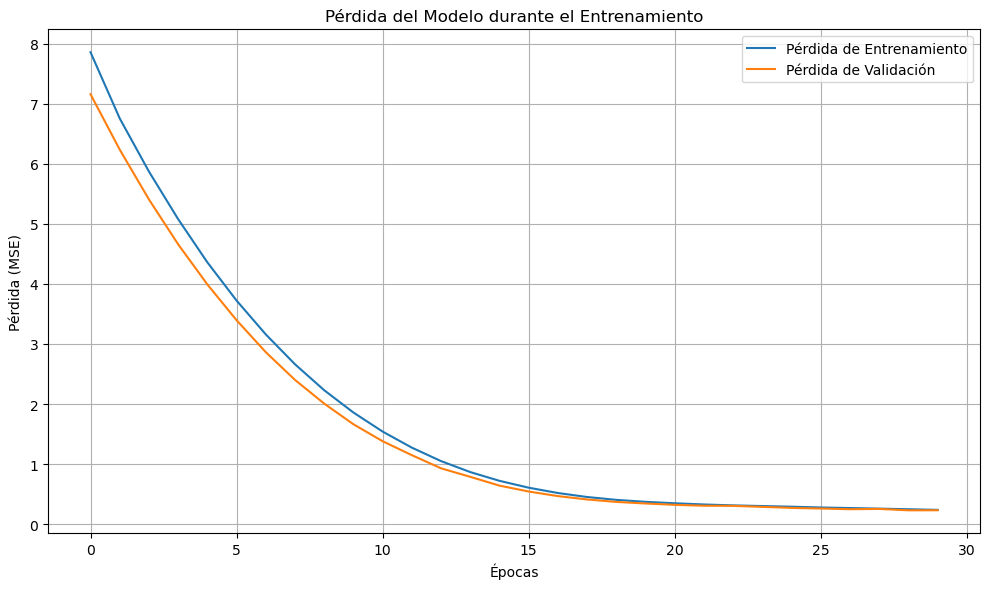

2/2 [==============================] - 11s 1s/step


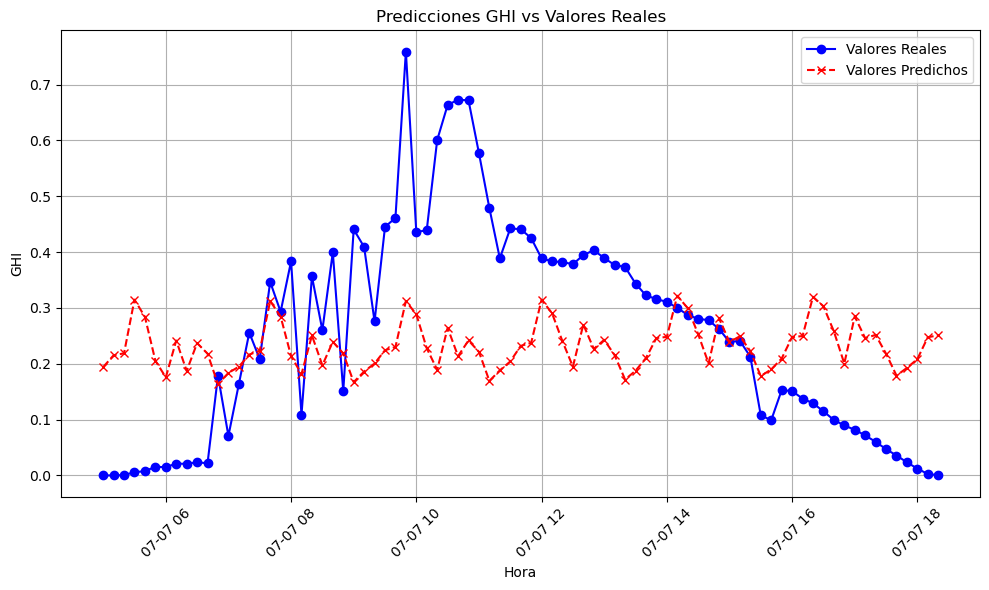

In [ ]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.legacy import RMSprop  # Importar la versión heredada
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Función para buscar la imagen más cercana en un rango de segundos
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.jpg"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, filtrando las parejas completas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    valid_timestamps = []

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path) if image_path else None
        
        if img is not None:
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            valid_timestamps.append(timestamp)
        else:
            print(f"Imagen no encontrada para timestamp: {timestamp}")
    
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler, valid_timestamps

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])
        X_seq_ghi.append(y_ghi[i:i+seq_len])
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    min_length = min(len(timestamps), len(y_real.flatten()), len(y_pred.flatten()))
    timestamps = timestamps[:min_length]
    y_real = y_real.flatten()[:min_length]
    y_pred = y_pred.flatten()[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_real, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps, y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60
    data_points = int(delta_minutes // data_frequency_minutes)
    seq_len = max(min_seq_len, data_points // 3)
    num_pred = max(min_num_pred, data_points // 6)
    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16 y LSTM
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    vgg16_base.trainable = False

    image_input = Input(shape=(seq_len, 64, 64, 3))
    vgg16_features = TimeDistributed(vgg16_base)(image_input)
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    lstm_out = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(concat)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(num_pred, kernel_regularizer=l2(0.01))(lstm_out)

    model = Model([image_input, numeric_input], output)
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')

    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=30, batch_size=16)

    return model, history

# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'
fecha_fin_entrenamiento = '2023-07-06 18:20:00'
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI con el filtro de parejas válidas
image_folder = 'Images/ACMF_test'
X_images_train, y_ghi_train, scaler_train, valid_timestamps_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Definir rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'
fecha_fin_prediccion = '2023-07-07 18:20:00'
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]
X_images_test, y_ghi_test, scaler_test, valid_timestamps_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

if len(X_images_train) > seq_len:
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    def plot_training_history(history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.title("Pérdida del Modelo durante el Entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    if len(X_images_test) > seq_len:
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")
